# Kaggle Sberbank Challenge

# Data Import
The data for this challenged was downloaged from the kaggle website.  
https://www.kaggle.com/c/sberbank-russian-housing-market/data


In [96]:
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer

%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
testing = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

In [3]:
train.shape

(30471, 292)

In [4]:
testing.shape

(7662, 291)

# Cleaning

Let's see what we have for factors

In [5]:
train.columns.values

array(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq', 'state',
       'product_type', 'sub_area', 'area_m', 'raion_popul',
       'green_zone_part', 'indust_part', 'children_preschool',
       'preschool_quota', 'preschool_education_centers_raion',
       'children_school', 'school_quota', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25', 'culture_objects_top_25_raion',
       'shopping_centers_raion', 'office_raion',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'full_all', 'male_f', 'female_f',
       'young_all', 'young_male', 'young

There are a lot of factors here.  I'm going to take a look at the dictionary doc and start working my way through them.


## price, our target variable
Let's look at our target variable and the primary variables first.

In [6]:
train.price_doc.describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

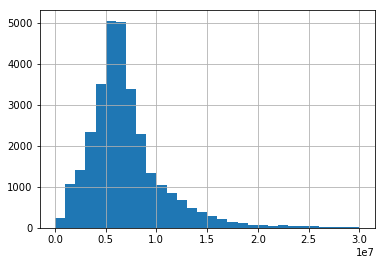

In [7]:
train.price_doc.hist(bins=30, range=[0,3e7])


## id variable
id variable appears to be just an index.  I will drop it from the data.

In [8]:
train.drop('id', axis=1, inplace=True)
testing.drop('id', axis=1, inplace=True)

## timestamp
The timestamp may or may not be valuable.  Let's pull out the month and year into seperate columns and take a look at how they are distributed.   

In [9]:
train['year'], train['month'], train['dayofmon']  = train['timestamp'].str.split('-',2).str
train.drop('timestamp', axis=1, inplace=True)

##for testing data as well
testing['year'], testing['month'], testing['dayofmon']  = testing['timestamp'].str.split('-',2).str
testing.drop('timestamp', axis=1, inplace=True)


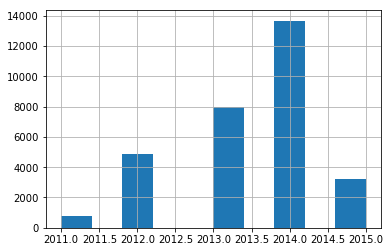

In [10]:
train['year'].astype('int').hist()

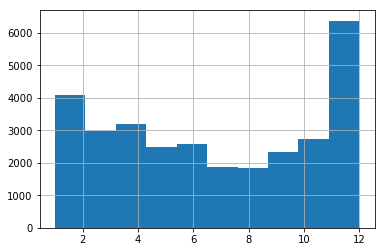

In [11]:
train['month'].astype('int').hist()

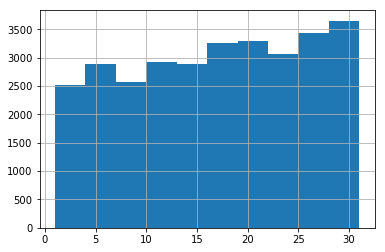

In [12]:
train['dayofmon'].astype('int').hist()

Let's turn these into categorical variables.

In [13]:
train['year'] = train['year'].astype('category')
train['month'] = train['month'].astype('category')
train['dayofmon'] = train['dayofmon'].astype('category')

##For test data as well
testing['year'] = testing['year'].astype('category')
testing['month'] = testing['month'].astype('category')
testing['dayofmon'] = testing['dayofmon'].astype('category')

## Square meters
There are two variables for size one is the living space and the other includes the full space including "loggias, balconies, and other non-residential areas".

First let's see how different life and full are.  

In [14]:
train['life_sq'].mean()

34.403271338425775

In [15]:
train['full_sq'].mean()

54.21426930524105

In [16]:
sqDiff = train['full_sq'].mean() - train['life_sq'].mean()

So the average difference between the life and full is about 20m.  This may be useful.  


Let's check and see if we have any values where life>full.  Something which should not occur by definition.

In [17]:
train[(train['life_sq'] > train['full_sq'])]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,dayofmon
1084,44,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,13,22,1,0,52,4,6200000,2012,02,06
1188,9,44.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,9,18,0,10,53,9,6300000,2012,02,14
1822,18,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,8,23,0,3,55,9,5200000,2012,04,09
1863,30,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,48,91,1,68,155,7,5900000,2012,04,11
2009,5,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,10,14,0,2,50,5,5770000,2012,04,25
4385,73,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,14,25,0,3,88,14,11918400,2012,10,25
6336,37,191.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,5,9,0,2,17,6,5400000,2013,03,06
6531,80,88.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,13,17,0,1,79,11,13801229,2013,03,15
6993,73,77.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,2,3,0,0,6,1,6290256,2013,04,03
7208,31,195.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,12,36,1,8,100,10,6400000,2013,04,10


There are 37 columns where this is true.  Some may be erroneous, some may be typos.  I think a good strategy for these would be to set full= life + 20m in these cases below some limit to prevent duplicating likely typos(I see a 7478 in the list) .  

In [18]:
train['full_sq'] = np.where((train['life_sq'] > train['full_sq']) & (train['life_sq'] < 1000), train['life_sq'] + sqDiff,train['full_sq'])


Now let's look at distribution of the values

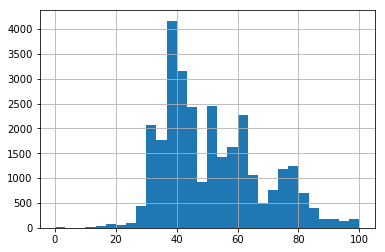

In [19]:
train['full_sq'].hist(bins=30, range=[0,100])

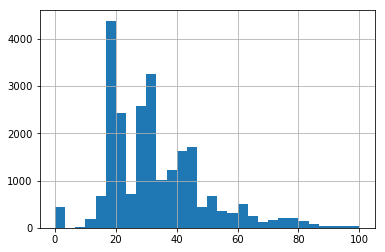

In [20]:
train['life_sq'].hist(bins=30, range=[0,100])

Looks like we have values at or near zero which is unlikely to be true.  Let's take a look at some.

In [21]:
train[train['full_sq'] < 10]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,dayofmon
6112,6.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,1,7,1,0,12,1,5177040,2013,02,22
16289,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,OwnerOccupier,...,1,7,1,0,12,1,4457400,2014,03,20
16738,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,OwnerOccupier,...,1,7,1,0,12,1,7820575,2014,03,31
17194,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,OwnerOccupier,...,11,14,0,1,72,9,13066000,2014,04,09
17932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,OwnerOccupier,...,1,7,1,0,12,1,4425000,2014,04,28
18600,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,OwnerOccupier,...,150,249,2,105,203,13,6675730,2014,05,19
22171,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,OwnerOccupier,...,2,12,0,1,10,0,6256186,2014,09,03
22722,1.0,1.0,1.0,25.0,1.0,2014.0,1.0,1.0,1.0,OwnerOccupier,...,4,6,0,0,5,1,4740000,2014,09,20
22795,1.0,1.0,7.0,19.0,1.0,2015.0,3.0,1.0,1.0,OwnerOccupier,...,1,6,0,0,6,1,5591788,2014,09,23
22871,1.0,1.0,1.0,1.0,1.0,2015.0,1.0,1.0,1.0,OwnerOccupier,...,4,6,0,0,5,1,4740000,2014,09,24


I think we can consider these invalid entries.  No apartment is 1 square meter.  Looking at these entries it appears that most of the other columns are missing as well.  Given how incomplete the primary traits are I'm going to drop these rows entirely.  

In [22]:
train.drop(train[train.full_sq < 10].index, inplace=True)

Now let's take a look at life_sq

In [23]:
train[train['life_sq'] < 5]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,dayofmon
104,26.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,14,33,1,3,72,12,4146000,2011,10,13
858,78.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,5,6,0,0,11,2,552312,2012,01,19
1596,59.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,4,6,0,0,7,1,338570,2012,03,20
2778,38.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,4,6,0,0,10,1,675205,2012,07,06
3426,71.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,4,6,0,0,10,1,1438647,2012,08,31
3800,57.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,1,7,0,0,8,0,5049071,2012,09,24
4138,61.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,150,249,2,105,203,13,4618597,2012,10,10
4311,44.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,1,12,1,0,16,1,4741970,2012,10,22
5879,61.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,4,6,0,0,4,1,5419778,2013,02,02
9676,66.0,1.0,16.0,17.0,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,...,1,12,1,0,16,1,5818280,2013,08,07


This looks similar to what we had while looking at cases where life was larger than full.  A lot of columns with 0 or 1. I'm going to apply the same logic and replace life with the full value - difference in means for these.  

In [24]:
train['life_sq'] = np.where((train['life_sq'] < 5),train['full_sq'] - sqDiff,train['life_sq'])

In [25]:
train['full_sq'].isnull().sum()

0

So no null values in full_sq

In [26]:
train['life_sq'].isnull().sum()

6382

Quite a few in life_sq, approximately 20%.  I've got 2 choices I think.  I can try and impute the missing values or drop this feature entirely assuming that the full_sq footage will capture any of the relationship between square footage and price.  I think for now I will drop life_sq.  I may revisit this later to see if adding it back in helps.  

In [27]:
train.drop('life_sq', axis=1, inplace=True)

##for the test data as well
testing.drop('life_sq', axis=1, inplace=True)

## floor

Now let's take a look at the floor variables, floor and max_floor.

Starting with how many missing values there are and how the data is distributed.  

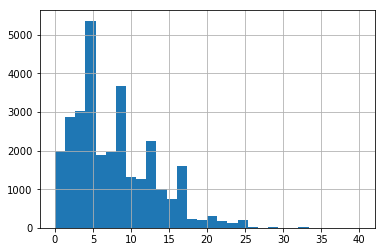

In [28]:
train['floor'].hist(bins=30, range=[0,40])

In [29]:
train['floor'].isnull().sum()

167

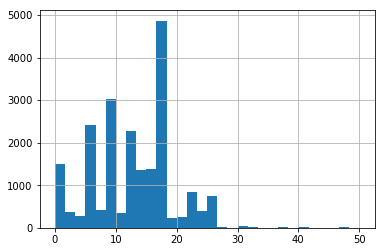

In [30]:
train['max_floor'].hist(bins=30, range=[0,50])

In [31]:
train['max_floor'].isnull().sum()

9571

So the floor value only has 167 missing.  Let's take a look.

In [32]:
train[train['floor'].isnull()]

,full_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,dayofmon
178,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Kurkino,...,1,3,0,0,10,0,11500000,2011,10,22
187,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,...,9,30,0,7,66,16,8300000,2011,10,24
195,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,...,14,32,0,7,69,12,2000000,2011,10,25
215,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Chertanovo Juzhnoe,...,7,18,1,1,41,5,2825000,2011,10,26
294,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Novogireevo,...,7,17,0,9,51,11,1000000,2011,11,05
387,76.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Juzhnoe Butovo,...,1,9,1,0,17,1,9300000,2011,11,17
428,34.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Izmajlovo,...,10,16,0,4,75,8,4480000,2011,11,22
508,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Chertanovo Severnoe,...,5,28,1,5,42,11,5700000,2011,11,30
519,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nizhegorodskoe,...,34,57,0,15,107,19,4000000,2011,12,01
650,63.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Teplyj Stan,...,5,26,0,2,33,7,9100000,2011,12,17


These records look pretty incomplete in general.  Going to drop these rows for now rather than trying to impute multiple columns.

In [33]:
train.drop(train[train['floor'].isnull()].index, inplace=True)

max_floor is missing nearly 1/3 of it's values. Dropping this column for now rather than trying to impute the values.  I may revisit this later.  

In [34]:
train.drop('max_floor', axis=1, inplace=True)

##same for testing data
testing.drop('max_floor', axis=1, inplace=True)

## material

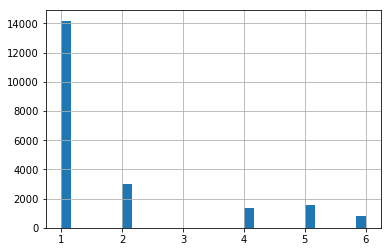

In [35]:
train['material'].hist(bins=30)

In [36]:
train['material'].isnull().sum()

9404

So another feature with 1/3 of the values missing.  I will drop it for the moment.  

In [37]:
train.drop('material', axis=1, inplace=True)

##same for test data
testing.drop('material', axis=1, inplace=True)

## build_year

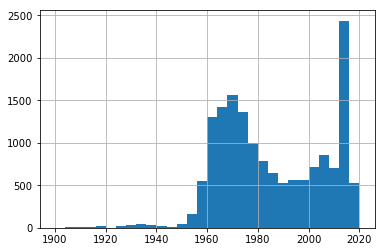

In [38]:
train['build_year'].hist(bins=30, range=[1900, 2020])

In [39]:
train['build_year'].isnull().sum()

13436

In [40]:
train['build_year'].describe()

count    1.684600e+04
mean     3.071340e+03
std      1.544794e+05
min      0.000000e+00
25%      1.967000e+03
50%      1.979000e+03
75%      2.005000e+03
max      2.005201e+07
Name: build_year, dtype: float64

Lots of missing values on this one as well.  Dropping for the moment

In [41]:
train.drop('build_year', axis=1, inplace=True)

## same for test data
testing.drop('build_year', axis=1, inplace=True)

## num_room

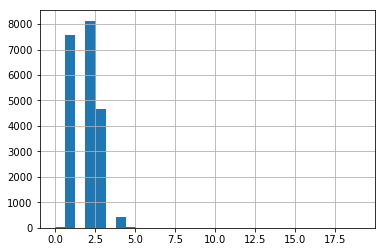

In [42]:
train['num_room'].hist(bins=30)

In [43]:
train['num_room'].isnull().sum()

9404

In [44]:
train.drop('num_room', axis=1, inplace=True)

##same for testing data
testing.drop('num_room', axis=1, inplace=True)

## kitch_sq

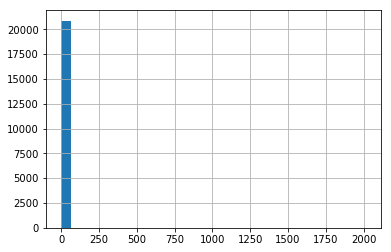

In [45]:
train['kitch_sq'].hist(bins=30)

In [46]:
train['kitch_sq'].isnull().sum()

9404

In [47]:
train.drop('kitch_sq', axis=1, inplace=True)

##same for testing data
testing.drop('kitch_sq', axis=1, inplace=True)

## state

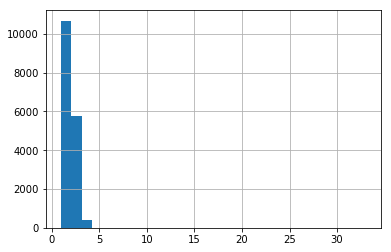

In [48]:
train['state'].hist(bins=30)

In [49]:
train['state'].isnull().sum()

13391

In [50]:
train.drop('state', axis=1, inplace=True)

##same for test data
testing.drop('state', axis=1, inplace=True)

## product_type

In [51]:
train['product_type'].value_counts()

Investment       19371
OwnerOccupier    10911
Name: product_type, dtype: int64

In [52]:
train['product_type'].isnull().sum()

0

This one looks good.  Changing it to categorical.

In [53]:
train['product_type'] = train['product_type'].astype('category')

##same for testing data
testing['product_type'] = testing['product_type'].astype('category')

## sub_area

In [54]:
train['sub_area'].value_counts()

Poselenie Sosenskoe               1773
Nekrasovka                        1606
Poselenie Vnukovskoe              1368
Poselenie Moskovskij               922
Poselenie Voskresenskoe            681
Mitino                             678
Tverskoe                           673
Krjukovo                           518
Mar'ino                            506
Poselenie Filimonkovskoe           496
Juzhnoe Butovo                     449
Poselenie Shherbinka               439
Solncevo                           419
Zapadnoe Degunino                  409
Poselenie Desjonovskoe             358
Otradnoe                           352
Nagatinskij Zaton                  324
Bogorodskoe                        305
Nagornoe                           301
Strogino                           300
Tekstil'shhiki                     298
Izmajlovo                          297
Ljublino                           296
Gol'janovo                         295
Severnoe Tushino                   281
Chertanovo Juzhnoe       

In [55]:
train['sub_area'].isnull().sum()

0

This one looks good. Changing it to categorical.

In [56]:
train['sub_area'] = train['sub_area'].astype('category')

##same for testing data
testing['sub_area'] = testing['sub_area'].astype('category')

## imputing

In [57]:
sum(testing['product_type']== 'OwnerOccupier')

2631

In [58]:
sum(testing['product_type']== 'Investment')

4998

In [59]:
testing.product_type[testing['product_type'].isnull()] = 'Investment'

In [60]:
sum(testing['product_type'].isnull())

0

## other variables

There are a ton of other variables in this data set.  Let's first explore how complete each one is.

In [61]:
features = train.isnull().sum()

In [62]:
features[features>0]

preschool_quota                           6600
school_quota                              6597
hospital_beds_raion                      14326
raion_build_count_with_material_info      4946
build_count_block                         4946
build_count_wood                          4946
build_count_frame                         4946
build_count_brick                         4946
build_count_monolith                      4946
build_count_panel                         4946
build_count_foam                          4946
build_count_slag                          4946
build_count_mix                           4946
raion_build_count_with_builddate_info     4946
build_count_before_1920                   4946
build_count_1921-1945                     4946
build_count_1946-1970                     4946
build_count_1971-1995                     4946
build_count_after_1995                    4946
metro_min_walk                              25
metro_km_walk                               25
railroad_stat

In [63]:
train.dropna(axis=1, inplace=True)
train.drop('green_part_2000',axis=1, inplace=True)

In [64]:
testing.dropna(axis=1, inplace=True)

# Model Training and testing

Let's build some models and see how they do.  I want to break out some validation data to try out the models.

In [65]:
##convert some category variables to codes
codes_sub_area = dict(enumerate(train.sub_area.cat.categories)) 
train['sub_area'] = train['sub_area'].cat.codes
codes_product_type = dict(enumerate(train.product_type.cat.categories))
train['product_type'] = train['product_type'].cat.codes
codes_month = dict(enumerate(train.month.cat.categories)) 
train['month'] = train['month'].cat.codes
codes_year = dict(enumerate(train.year.cat.categories)) 
train['year'] = train['year'].cat.codes
codes_dayofmon = dict(enumerate(train.dayofmon.cat.categories)) 
train['dayofmon'] = train['dayofmon'].cat.codes

train['culture_objects_top_25'] = train['culture_objects_top_25'].astype('category')
codes_culture_objects_top_25 = dict(enumerate(train.culture_objects_top_25.cat.categories))
train['culture_objects_top_25'] = train['culture_objects_top_25'].cat.codes

train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].astype('category')
codes_thermal_power_plant_raion = dict(enumerate(train.thermal_power_plant_raion.cat.categories))
train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].cat.codes

train['incineration_raion'] = train['incineration_raion'].astype('category')
codes_incineration_raion = dict(enumerate(train.incineration_raion.cat.categories))
train['incineration_raion'] = train['incineration_raion'].cat.codes

train['oil_chemistry_raion'] = train['oil_chemistry_raion'].astype('category')
codes_oil_chemistry_raion = dict(enumerate(train.oil_chemistry_raion.cat.categories))
train['oil_chemistry_raion'] = train['oil_chemistry_raion'].cat.codes

train['radiation_raion'] = train['radiation_raion'].astype('category')
codes_radiation_raion = dict(enumerate(train.radiation_raion.cat.categories))
train['radiation_raion'] = train['radiation_raion'].cat.codes

train['railroad_terminal_raion'] = train['railroad_terminal_raion'].astype('category')
codes_railroad_terminal_raion = dict(enumerate(train.railroad_terminal_raion.cat.categories))
train['railroad_terminal_raion'] = train['railroad_terminal_raion'].cat.codes

train['big_market_raion'] = train['big_market_raion'].astype('category')
codes_big_market_raion = dict(enumerate(train.big_market_raion.cat.categories))
train['big_market_raion'] = train['big_market_raion'].cat.codes

train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].astype('category')
codes_nuclear_reactor_raion = dict(enumerate(train.nuclear_reactor_raion.cat.categories))
train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].cat.codes

train['detention_facility_raion'] = train['detention_facility_raion'].astype('category')
codes_detention_facility_raion = dict(enumerate(train.detention_facility_raion.cat.categories))
train['detention_facility_raion'] = train['detention_facility_raion'].cat.codes

train['water_1line'] = train['water_1line'].astype('category')
codes_water_1line = dict(enumerate(train.water_1line.cat.categories))
train['water_1line'] = train['water_1line'].cat.codes

train['big_road1_1line'] = train['big_road1_1line'].astype('category')
codes_big_road1_1line = dict(enumerate(train.big_road1_1line.cat.categories))
train['big_road1_1line'] = train['big_road1_1line'].cat.codes

train['railroad_1line'] = train['railroad_1line'].astype('category')
codes_railroad_1line = dict(enumerate(train.railroad_1line.cat.categories))
train['railroad_1line'] = train['railroad_1line'].cat.codes

train['ecology'] = train['ecology'].astype('category')
codes_ecology = dict(enumerate(train.ecology.cat.categories))
train['ecology'] = train['ecology'].cat.codes


training, validation = train_test_split(train, test_size = 0.2)

training_Y = training['price_doc']
training_X = training.drop('price_doc', axis=1)
validation_Y = validation['price_doc'].values
validation_X = validation.drop('price_doc', axis=1)


In [66]:
##Same transformations on test data

codest_sub_area = dict(enumerate(testing.sub_area.cat.categories)) 
testing['sub_area'] = testing['sub_area'].cat.codes
codest_product_type = dict(enumerate(testing.product_type.cat.categories))
testing['product_type'] = testing['product_type'].cat.codes
codest_month = dict(enumerate(testing.month.cat.categories)) 
testing['month'] = testing['month'].cat.codes
codest_year = dict(enumerate(testing.year.cat.categories)) 
testing['year'] = testing['year'].cat.codes
codest_dayofmon = dict(enumerate(testing.dayofmon.cat.categories)) 
testing['dayofmon'] = testing['dayofmon'].cat.codes

testing['culture_objects_top_25'] = testing['culture_objects_top_25'].astype('category')
codest_culture_objects_top_25 = dict(enumerate(testing.culture_objects_top_25.cat.categories))
testing['culture_objects_top_25'] = testing['culture_objects_top_25'].cat.codes

testing['thermal_power_plant_raion'] = testing['thermal_power_plant_raion'].astype('category')
codest_thermal_power_plant_raion = dict(enumerate(testing.thermal_power_plant_raion.cat.categories))
testing['thermal_power_plant_raion'] = testing['thermal_power_plant_raion'].cat.codes

testing['incineration_raion'] = testing['incineration_raion'].astype('category')
codest_incineration_raion = dict(enumerate(testing.incineration_raion.cat.categories))
testing['incineration_raion'] = testing['incineration_raion'].cat.codes

testing['oil_chemistry_raion'] = testing['oil_chemistry_raion'].astype('category')
codest_oil_chemistry_raion = dict(enumerate(testing.oil_chemistry_raion.cat.categories))
testing['oil_chemistry_raion'] = testing['oil_chemistry_raion'].cat.codes

testing['radiation_raion'] = testing['radiation_raion'].astype('category')
codest_radiation_raion = dict(enumerate(testing.radiation_raion.cat.categories))
testing['radiation_raion'] = testing['radiation_raion'].cat.codes

testing['railroad_terminal_raion'] = testing['railroad_terminal_raion'].astype('category')
codest_railroad_terminal_raion = dict(enumerate(testing.railroad_terminal_raion.cat.categories))
testing['railroad_terminal_raion'] = testing['railroad_terminal_raion'].cat.codes

testing['big_market_raion'] = testing['big_market_raion'].astype('category')
codest_big_market_raion = dict(enumerate(testing.big_market_raion.cat.categories))
testing['big_market_raion'] = testing['big_market_raion'].cat.codes

testing['nuclear_reactor_raion'] = testing['nuclear_reactor_raion'].astype('category')
codest_nuclear_reactor_raion = dict(enumerate(testing.nuclear_reactor_raion.cat.categories))
testing['nuclear_reactor_raion'] = testing['nuclear_reactor_raion'].cat.codes

testing['detention_facility_raion'] = testing['detention_facility_raion'].astype('category')
codest_detention_facility_raion = dict(enumerate(testing.detention_facility_raion.cat.categories))
testing['detention_facility_raion'] = testing['detention_facility_raion'].cat.codes

testing['water_1line'] = testing['water_1line'].astype('category')
codest_water_1line = dict(enumerate(testing.water_1line.cat.categories))
testing['water_1line'] = testing['water_1line'].cat.codes

testing['big_road1_1line'] = testing['big_road1_1line'].astype('category')
codest_big_road1_1line = dict(enumerate(testing.big_road1_1line.cat.categories))
testing['big_road1_1line'] = testing['big_road1_1line'].cat.codes

testing['railroad_1line'] = testing['railroad_1line'].astype('category')
codest_railroad_1line = dict(enumerate(testing.railroad_1line.cat.categories))
testing['railroad_1line'] = testing['railroad_1line'].cat.codes

testing['ecology'] = testing['ecology'].astype('category')
codest_ecology = dict(enumerate(testing.ecology.cat.categories))
testing['ecology'] = testing['ecology'].cat.codes





In [67]:
testing

,full_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_education_centers_raion,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,year,month,dayofmon
0,39.00,2,0,38,2.615514e+07,178264,0.137846,0.041116,14080,11,...,0,1,10,1,0,14,1,0,5,0
1,79.20,8,1,102,2.553630e+07,4001,0.496315,0.007122,275,0,...,0,2,11,0,1,12,1,0,5,0
2,40.50,3,0,84,9.946335e+06,139322,0.065409,0.225825,6400,7,...,0,10,21,0,10,71,11,0,5,0
3,62.80,17,1,104,2.149409e+07,7122,0.262459,0.017647,489,0,...,0,0,10,0,0,2,0,0,5,0
4,40.00,17,1,102,2.553630e+07,4001,0.496315,0.007122,275,0,...,0,2,12,0,1,11,1,0,5,0
5,48.43,21,1,24,9.629358e+06,89467,0.343754,0.238617,3903,5,...,12,23,42,1,13,123,7,0,5,0
6,38.80,15,1,123,1.132409e+07,113897,0.083810,0.371149,8340,5,...,0,5,14,0,3,17,2,0,5,0
7,43.10,5,1,101,6.677245e+07,9553,0.336177,0.072158,656,0,...,0,3,12,0,0,6,3,0,5,0
8,45.40,9,0,135,1.531990e+07,21040,0.051549,0.036270,1491,1,...,0,1,7,0,0,7,0,0,5,0
9,43.30,7,1,102,2.553630e+07,4001,0.496315,0.007122,275,0,...,0,2,9,0,0,7,0,0,5,0


## Error calculation
Erorr for this contest is rmsle.  Need to define a funciton for this measurement to test my results.

In [68]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Random Forest

In [69]:
#model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features='auto', min_samples_leaf=50, verbose=1, n_jobs=3)
#model_rf.fit(training_X, training_Y)

In [70]:
#predY_rf = model_rf.predict(validation_X)

In [71]:
#rmsle(validation_Y,predY_rf)

## XGBoost


In [72]:
trainXGB = xgb.DMatrix(training_X, label=training_Y)
validateXGB = xgb.DMatrix(validation_X, label=validation_Y)
params = {'nthread':3, 'max_depth':6, 'eta':.3}
model_xgb = xgb.train(params,trainXGB)

In [73]:
predY_xgb = model_xgb.predict(validateXGB)

In [74]:
rmsle(validation_Y,predY_xgb)

0.48639672478846274

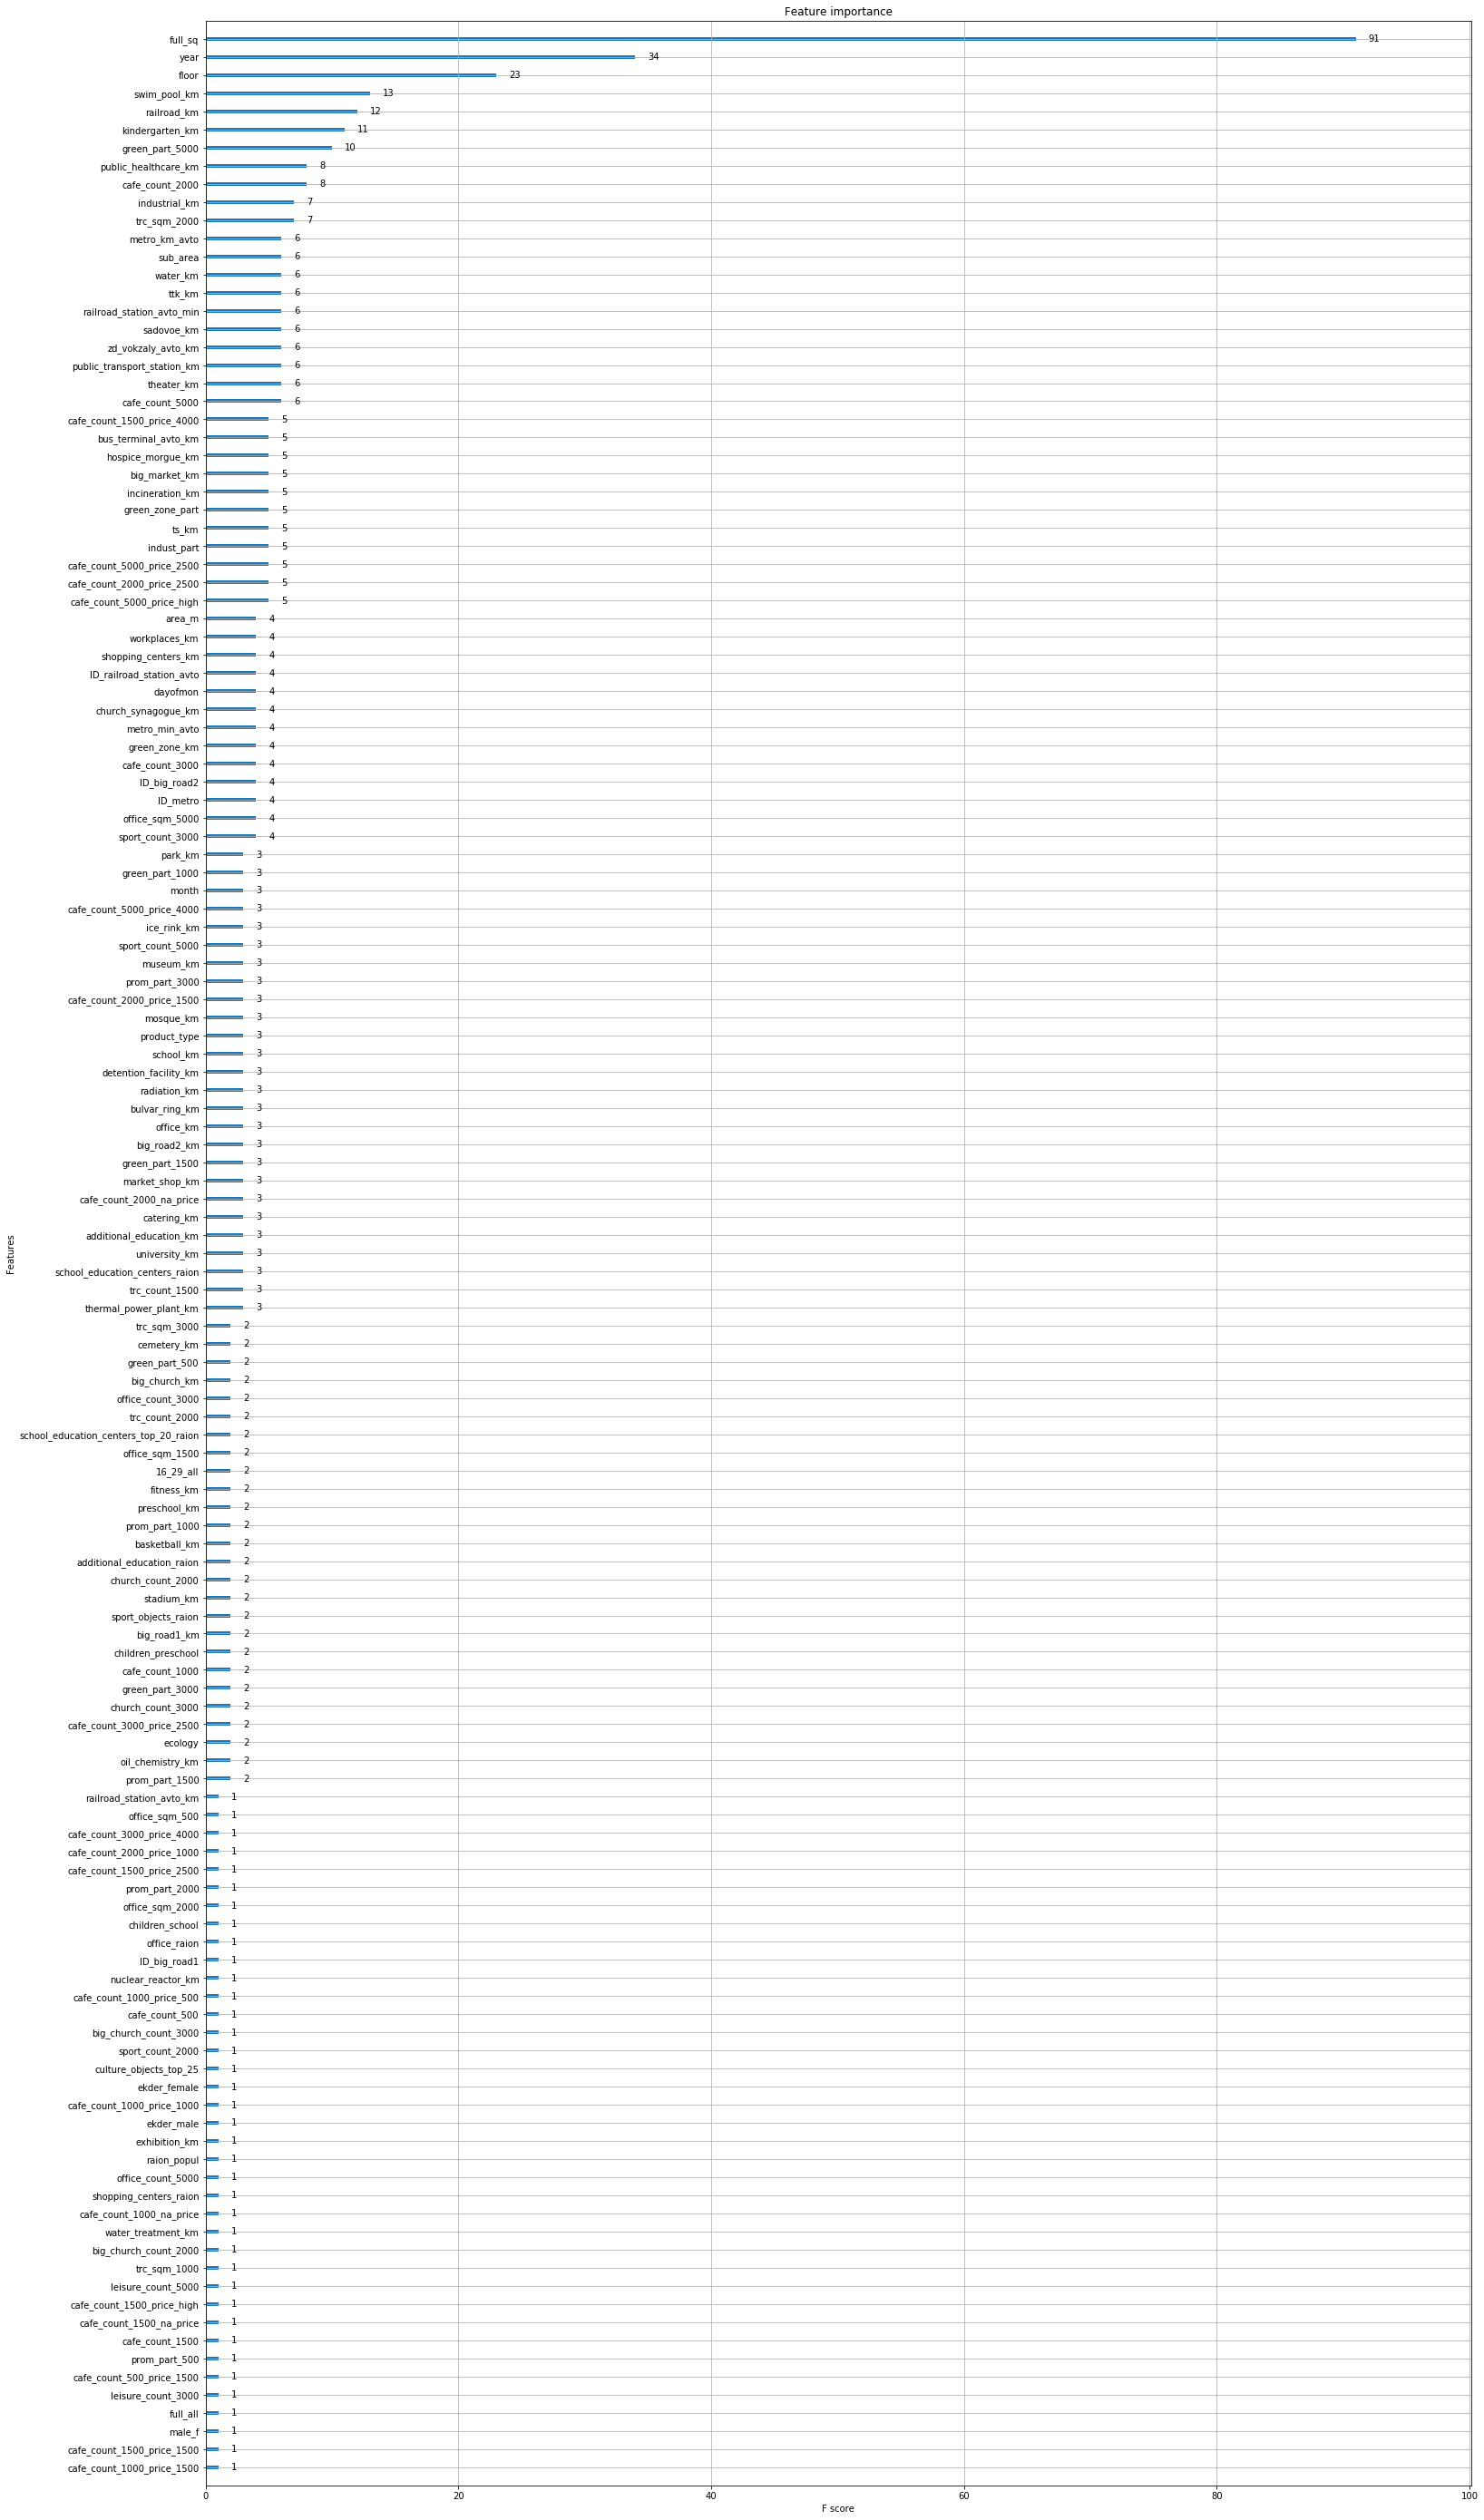

In [75]:
fig, ax = plt.subplots(figsize=(25, 50))
xgb.plot_importance(model_xgb, ax=ax)


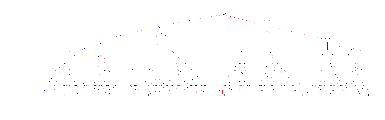

In [76]:
xgb.plot_tree(model_xgb, num_trees=2)

## Final model build and submission

Now that we have tested our models on the validation data, let's retrain with all the data before predicting on the test set

In [77]:
train_Y = train['price_doc']
train_X = train.drop('price_doc', axis=1)

trainXGB_final = xgb.DMatrix(train_X, label=train_Y)
testingXGB = xgb.DMatrix(testing)

model_xgb_final = xgb.train(params,trainXGB_final)

In [79]:
predY_xgb_final = model_xgb_final.predict(testingXGB)

In [83]:
predY_xgb_final

array([ 4846003.5,  6963772. ,  4855948. , ...,  4289981. ,  5229711. ,
        8126372. ], dtype=float32)

In [100]:
submission = pd.DataFrame()
submission['id'] = range(30474,38136)
submission['price_doc'] = predY_xgb_final

sub_file = 'submission.csv'
submission.to_csv(sub_file, index=False)


In [97]:
submission


,id,price_doc
0,30474,4846003.50
1,30475,6963772.00
2,30476,4855948.00
3,30477,4706659.50
4,30478,4044739.00
5,30479,7362749.50
6,30480,3599572.50
7,30481,3617110.00
8,30482,3689398.75
9,30483,3428477.50
